In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#GPU使えるようにする
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# # 画像の前処理（テンソル化 & 正規化）
# transform = transforms.Compose([
#     transforms.ToTensor(),  # 画像をTensor型に変換(H, W, C) → (C, H, W) ＆値を 0〜1 にスケール
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # -1〜1の範囲に正規化
# ])
# #transforms.Normalize((平均R, 平均G, 平均B), (標準偏差R, 標準偏差G, 標準偏差B))

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         # ランダムに切り抜き
    transforms.RandomHorizontalFlip(),            # 左右反転
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), # 平均
                         (0.2470, 0.2435, 0.2616)) # 標準偏差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 分類の定義
classes = ("airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck")


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


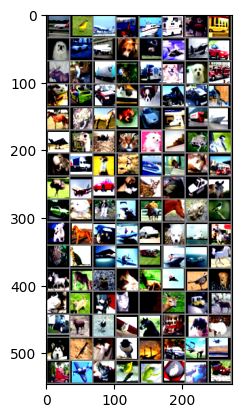

airplane bird  airplane truck ship  truck deer  automobile dog   automobile airplane dog   deer  airplane airplane automobile deer  bird  truck frog  truck dog   dog   truck frog  automobile automobile cat   dog   truck automobile cat   horse frog  horse frog  automobile cat   truck ship  airplane bird  ship  cat   dog   airplane frog  bird  frog  truck bird  deer  ship  cat   cat   truck bird  airplane automobile dog   deer  frog  automobile horse automobile dog   dog   ship  horse horse frog  bird  horse horse automobile ship  automobile dog   ship  horse frog  cat   airplane airplane truck ship  ship  horse horse deer  frog  cat   deer  airplane bird  dog   dog   dog   cat   cat   cat   deer  truck deer  truck deer  bird  cat   horse truck dog   cat   dog   bird  cat   bird  ship  automobile deer  airplane truck airplane frog  bird  frog  cat   truck truck


In [5]:
# 画像の表示
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 学習画像をランダムに取得
dataiter = iter(trainloader)
images, labels = next(dataiter)
# 画像の表示
imshow(torchvision.utils.make_grid(images))
# バッチサイズの表示
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 畳み込み層(入力チャネル数,出力チャネル数,カーネルサイズ)
        self.conv1 = nn.Conv2d(3, 6, 5)


        self.conv2 = nn.Conv2d(6, 10, 5)
        self.bn1 = nn.BatchNorm2d(10)

        # Maxプーリング層(カーネルサイズ,カーネルサイズ)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(10, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 32, 5)


        """ 全結合層(入力,出力)
        入力は今まで処理してきた画像を一次元のベクトルにしたときの数"""
        self.fc1 = nn.Linear(16*3*3, 120)
        self.bn3 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # ドロップアウト
        self.dropout = nn.Dropout(0.25)
#cnnのところで一つbnでfc(全結合)でドロップアウト
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x=self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# train_losses = []
# test_losses = []


# for epoch in range(40):  # データセットを複数回ループ
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # inputを取得する。dataは[inputs, labels]のリスト
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         # モデルに保存されているパラメータ勾配をゼロにする
#         optimizer.zero_grad()
#         # 予測結果を出力
#         outputs = net(inputs)
#         #　誤差関数から、誤差を計測
#         loss = criterion(outputs, labels)
#         # 誤差をフィードバック
#         loss.backward()
#         optimizer.step()
#         # 統計を出力
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0
#         # --- 各エポック終了後にロスを記録 ---
#     net.eval()
#     train_loss = 0.0
#     test_loss = 0.0

#     with torch.no_grad():
#         for data in trainloader:
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             train_loss += loss.item()
#         for data in testloader:
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()

#     train_losses.append(train_loss / len(trainloader))
#     test_losses.append(test_loss / len(testloader))
#     net.train()



In [ ]:
# import torch
# import time

# train_losses = []
# test_losses = []

# # GPU最適化：データローダとモデルをできるだけ非同期処理で回す
# for epoch in range(40):
#     net.train()
#     running_loss = 0.0
#     start_time = time.time()

#     for i, data in enumerate(trainloader):
#         inputs, labels = data
#         inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # 約391バッチ → 40バッチごとに出力（10分割）
#         if (i + 1) % 40 == 0:
#             print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}")
#             running_loss = 0.0

#     # 評価
#     net.eval()
#     train_loss = 0.0
#     test_loss = 0.0

#     with torch.no_grad():
#         for inputs, labels in trainloader:
#             inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             train_loss += loss.item()

#         for inputs, labels in testloader:
#             inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()

#     train_losses.append(train_loss / len(trainloader))
#     test_losses.append(test_loss / len(testloader))

#     elapsed = time.time() - start_time
#     print(f"✅ Epoch {epoch+1} 完了 | 🕒 {elapsed:.1f}s | Train Loss: {train_losses[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}")


In [ ]:
# import torch
# import torch.cuda.amp as amp
# import time
# from tqdm import tqdm
# import copy
# best_model=
# # AMPのためのスケーラー
# scaler = amp.GradScaler()

# # 高速化設定
# torch.backends.cudnn.benchmark = True

# train_losses = []
# test_losses = []

# for epoch in range(40):
#     net.train()
#     running_loss = 0.0
#     start_time = time.time()

#     # tqdmでプログレスバー付きループ
#     for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}")):
#         inputs, labels = data
#         inputs = inputs.to(device, non_blocking=True)
#         labels = labels.to(device, non_blocking=True)

#         optimizer.zero_grad()

#         # 混合精度でforward/backward
#         with amp.autocast():
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item()

#         if (i + 1) % 40 == 0:
#             print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}")
#             running_loss = 0.0

#     # 評価
#     net.eval()
#     train_loss = 0.0
#     test_loss = 0.0

#     with torch.no_grad():
#         for inputs, labels in trainloader:
#             inputs = inputs.to(device, non_blocking=True)
#             labels = labels.to(device, non_blocking=True)
#             with amp.autocast():
#                 outputs = net(inputs)
#                 loss = criterion(outputs, labels)
#             train_loss += loss.item()

#         for inputs, labels in testloader:
#             inputs = inputs.to(device, non_blocking=True)
#             labels = labels.to(device, non_blocking=True)
#             with amp.autocast():
#                 outputs = net(inputs)
#                 loss = criterion(outputs, labels)
#             test_loss += loss.item()

#     train_losses.append(train_loss / len(trainloader))
#     test_losses.append(test_loss / len(testloader))


#     if best_loss<test_loss:
#       best_model=deepcopy()

#     elapsed = time.time() - start_time
#     print(f"✅ Epoch {epoch+1} 完了 | 🕒 {elapsed:.1f}s | Train Loss: {train_losses[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}")


In [9]:
import torch
import torch.cuda.amp as amp
import time
from tqdm import tqdm

# AMP スケーラーと cuDNN 高速化
scaler = amp.GradScaler()
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

train_losses = []
test_losses = []
best_test_loss = float("inf")

for epoch in range(40):
    net.train()
    running_loss = 0.0
    start_time = time.time()

    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}")):
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        # 混合精度学習
        with amp.autocast():
            outputs = net(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        if (i + 1) % 40 == 0:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}")
            running_loss = 0.0

    # 評価モード
    net.eval()
    train_loss = 0.0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in trainloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with amp.autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            train_loss += loss.item()

        for inputs, labels in testloader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with amp.autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            test_loss += loss.item()

    train_avg = train_loss / len(trainloader)
    test_avg = test_loss / len(testloader)
    train_losses.append(train_avg)
    test_losses.append(test_avg)

    elapsed = time.time() - start_time
    print(f"✅ Epoch {epoch+1} 完了 | 🕒 {elapsed:.1f}s | Train Loss: {train_avg:.3f}, Test Loss: {test_avg:.3f}")

    # 最良モデルの保存
    if test_avg < best_test_loss:
        best_test_loss = test_avg
        torch.save(net.state_dict(), "best_model.pth")
        print(f" 最良モデルを保存しました（Test Loss: {best_test_loss:.3f}）")


<ipython-input-9-33c26c87fc3b>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]<ipython-input-9-33c26c87fc3b>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Epoch 1:  11%|█▏        | 44/391 [00:04<00:16, 21.00it/s]

[1,    40] loss: 2.198


Epoch 1:  21%|██        | 81/391 [00:06<00:21, 14.17it/s]

[1,    80] loss: 1.926


Epoch 1:  31%|███       | 121/391 [00:09<00:14, 18.68it/s]

[1,   120] loss: 1.795


Epoch 1:  42%|████▏     | 163/391 [00:11<00:11, 20.11it/s]

[1,   160] loss: 1.721


Epoch 1:  52%|█████▏    | 202/391 [00:13<00:08, 23.36it/s]

[1,   200] loss: 1.705


Epoch 1:  62%|██████▏   | 244/391 [00:15<00:07, 20.56it/s]

[1,   240] loss: 1.660


Epoch 1:  73%|███████▎  | 284/391 [00:17<00:05, 20.83it/s]

[1,   280] loss: 1.671


Epoch 1:  82%|████████▏ | 322/391 [00:20<00:05, 12.69it/s]

[1,   320] loss: 1.622


Epoch 1:  93%|█████████▎| 363/391 [00:22<00:01, 19.25it/s]

[1,   360] loss: 1.600


Epoch 1: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]
<ipython-input-9-33c26c87fc3b>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-9-33c26c87fc3b>:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


✅ Epoch 1 完了 | 🕒 45.1s | Train Loss: 1.550, Test Loss: 1.486
 最良モデルを保存しました（Test Loss: 1.486）


Epoch 2:  11%|█         | 43/391 [00:02<00:16, 21.27it/s]

[2,    40] loss: 1.574


Epoch 2:  21%|██        | 82/391 [00:04<00:16, 19.13it/s]

[2,    80] loss: 1.565


Epoch 2:  32%|███▏      | 125/391 [00:06<00:11, 22.18it/s]

[2,   120] loss: 1.544


Epoch 2:  41%|████▏     | 162/391 [00:08<00:12, 18.69it/s]

[2,   160] loss: 1.528


Epoch 2:  52%|█████▏    | 205/391 [00:10<00:08, 21.70it/s]

[2,   200] loss: 1.541


Epoch 2:  62%|██████▏   | 241/391 [00:12<00:10, 14.61it/s]

[2,   240] loss: 1.515


Epoch 2:  72%|███████▏  | 282/391 [00:15<00:05, 18.47it/s]

[2,   280] loss: 1.477


Epoch 2:  83%|████████▎ | 323/391 [00:17<00:03, 21.92it/s]

[2,   320] loss: 1.486


Epoch 2:  93%|█████████▎| 365/391 [00:19<00:01, 21.85it/s]

[2,   360] loss: 1.456


Epoch 2: 100%|██████████| 391/391 [00:20<00:00, 18.82it/s]


✅ Epoch 2 完了 | 🕒 42.8s | Train Loss: 1.467, Test Loss: 1.404
 最良モデルを保存しました（Test Loss: 1.404）


Epoch 3:  11%|█         | 43/391 [00:02<00:16, 21.71it/s]

[3,    40] loss: 1.454


Epoch 3:  21%|██        | 82/391 [00:03<00:14, 21.34it/s]

[3,    80] loss: 1.429


Epoch 3:  31%|███       | 122/391 [00:05<00:11, 22.93it/s]

[3,   120] loss: 1.432


Epoch 3:  42%|████▏     | 163/391 [00:07<00:11, 19.57it/s]

[3,   160] loss: 1.410


Epoch 3:  52%|█████▏    | 202/391 [00:10<00:13, 14.14it/s]

[3,   200] loss: 1.401


Epoch 3:  62%|██████▏   | 242/391 [00:12<00:07, 20.59it/s]

[3,   240] loss: 1.435


Epoch 3:  72%|███████▏  | 282/391 [00:14<00:04, 22.61it/s]

[3,   280] loss: 1.411


Epoch 3:  82%|████████▏ | 322/391 [00:16<00:03, 21.98it/s]

[3,   320] loss: 1.438


Epoch 3:  92%|█████████▏| 361/391 [00:18<00:01, 20.41it/s]

[3,   360] loss: 1.408


Epoch 3: 100%|██████████| 391/391 [00:20<00:00, 19.54it/s]


✅ Epoch 3 完了 | 🕒 41.9s | Train Loss: 1.393, Test Loss: 1.307
 最良モデルを保存しました（Test Loss: 1.307）


Epoch 4:  11%|█         | 43/391 [00:02<00:16, 20.65it/s]

[4,    40] loss: 1.385


Epoch 4:  21%|██▏       | 84/391 [00:04<00:14, 20.68it/s]

[4,    80] loss: 1.381


Epoch 4:  31%|███       | 122/391 [00:06<00:17, 15.45it/s]

[4,   120] loss: 1.374


Epoch 4:  41%|████▏     | 162/391 [00:09<00:12, 18.09it/s]

[4,   160] loss: 1.378


Epoch 4:  52%|█████▏    | 204/391 [00:11<00:08, 23.08it/s]

[4,   200] loss: 1.354


Epoch 4:  62%|██████▏   | 243/391 [00:13<00:07, 20.69it/s]

[4,   240] loss: 1.363


Epoch 4:  72%|███████▏  | 282/391 [00:14<00:05, 21.76it/s]

[4,   280] loss: 1.352


Epoch 4:  82%|████████▏ | 321/391 [00:16<00:03, 22.26it/s]

[4,   320] loss: 1.331


Epoch 4:  93%|█████████▎| 363/391 [00:18<00:01, 20.30it/s]

[4,   360] loss: 1.384


Epoch 4: 100%|██████████| 391/391 [00:21<00:00, 18.62it/s]


✅ Epoch 4 完了 | 🕒 42.5s | Train Loss: 1.296, Test Loss: 1.241
 最良モデルを保存しました（Test Loss: 1.241）


Epoch 5:  10%|█         | 41/391 [00:02<00:17, 20.01it/s]

[5,    40] loss: 1.339


Epoch 5:  21%|██        | 81/391 [00:04<00:22, 13.50it/s]

[5,    80] loss: 1.343


Epoch 5:  32%|███▏      | 124/391 [00:07<00:13, 19.93it/s]

[5,   120] loss: 1.307


Epoch 5:  42%|████▏     | 163/391 [00:09<00:11, 19.53it/s]

[5,   160] loss: 1.339


Epoch 5:  52%|█████▏    | 205/391 [00:11<00:08, 22.44it/s]

[5,   200] loss: 1.321


Epoch 5:  62%|██████▏   | 244/391 [00:13<00:07, 20.42it/s]

[5,   240] loss: 1.313


Epoch 5:  72%|███████▏  | 282/391 [00:14<00:05, 19.98it/s]

[5,   280] loss: 1.317


Epoch 5:  82%|████████▏ | 322/391 [00:17<00:04, 14.02it/s]

[5,   320] loss: 1.314


Epoch 5:  93%|█████████▎| 362/391 [00:20<00:01, 17.60it/s]

[5,   360] loss: 1.302


Epoch 5: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s]


✅ Epoch 5 完了 | 🕒 42.2s | Train Loss: 1.268, Test Loss: 1.196
 最良モデルを保存しました（Test Loss: 1.196）


Epoch 6:  11%|█         | 43/391 [00:03<00:25, 13.50it/s]

[6,    40] loss: 1.292


Epoch 6:  21%|██        | 83/391 [00:05<00:14, 21.61it/s]

[6,    80] loss: 1.315


Epoch 6:  32%|███▏      | 124/391 [00:07<00:12, 21.15it/s]

[6,   120] loss: 1.340


Epoch 6:  41%|████▏     | 162/391 [00:09<00:10, 21.47it/s]

[6,   160] loss: 1.301


Epoch 6:  52%|█████▏    | 204/391 [00:11<00:08, 20.82it/s]

[6,   200] loss: 1.302


Epoch 6:  62%|██████▏   | 243/391 [00:13<00:06, 21.82it/s]

[6,   240] loss: 1.270


Epoch 6:  72%|███████▏  | 282/391 [00:15<00:08, 12.71it/s]

[6,   280] loss: 1.312


Epoch 6:  83%|████████▎ | 323/391 [00:18<00:03, 22.34it/s]

[6,   320] loss: 1.279


Epoch 6:  93%|█████████▎| 362/391 [00:20<00:01, 19.68it/s]

[6,   360] loss: 1.270


Epoch 6: 100%|██████████| 391/391 [00:21<00:00, 18.14it/s]


✅ Epoch 6 完了 | 🕒 43.9s | Train Loss: 1.238, Test Loss: 1.177
 最良モデルを保存しました（Test Loss: 1.177）


Epoch 7:  11%|█         | 42/391 [00:02<00:16, 20.98it/s]

[7,    40] loss: 1.287


Epoch 7:  21%|██▏       | 84/391 [00:04<00:14, 21.27it/s]

[7,    80] loss: 1.272


Epoch 7:  31%|███       | 122/391 [00:06<00:13, 20.50it/s]

[7,   120] loss: 1.253


Epoch 7:  42%|████▏     | 165/391 [00:08<00:09, 22.69it/s]

[7,   160] loss: 1.258


Epoch 7:  51%|█████▏    | 201/391 [00:10<00:12, 14.62it/s]

[7,   200] loss: 1.278


Epoch 7:  62%|██████▏   | 244/391 [00:13<00:08, 17.40it/s]

[7,   240] loss: 1.280


Epoch 7:  72%|███████▏  | 281/391 [00:14<00:05, 20.93it/s]

[7,   280] loss: 1.251


Epoch 7:  83%|████████▎ | 323/391 [00:17<00:03, 20.17it/s]

[7,   320] loss: 1.269


Epoch 7:  93%|█████████▎| 362/391 [00:18<00:01, 21.85it/s]

[7,   360] loss: 1.281


Epoch 7: 100%|██████████| 391/391 [00:20<00:00, 19.18it/s]


✅ Epoch 7 完了 | 🕒 42.7s | Train Loss: 1.240, Test Loss: 1.176
 最良モデルを保存しました（Test Loss: 1.176）


Epoch 8:  10%|█         | 40/391 [00:02<00:15, 22.02it/s]

[8,    40] loss: 1.274


Epoch 8:  21%|██        | 82/391 [00:04<00:14, 21.82it/s]

[8,    80] loss: 1.232


Epoch 8:  32%|███▏      | 124/391 [00:06<00:12, 20.97it/s]

[8,   120] loss: 1.259


Epoch 8:  41%|████      | 161/391 [00:08<00:17, 12.80it/s]

[8,   160] loss: 1.260


Epoch 8:  52%|█████▏    | 202/391 [00:11<00:10, 17.62it/s]

[8,   200] loss: 1.247


Epoch 8:  62%|██████▏   | 244/391 [00:13<00:07, 20.01it/s]

[8,   240] loss: 1.254


Epoch 8:  72%|███████▏  | 283/391 [00:15<00:05, 21.00it/s]

[8,   280] loss: 1.254


Epoch 8:  83%|████████▎ | 323/391 [00:17<00:03, 20.86it/s]

[8,   320] loss: 1.264


Epoch 8:  93%|█████████▎| 363/391 [00:19<00:01, 18.72it/s]

[8,   360] loss: 1.249


Epoch 8: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]


✅ Epoch 8 完了 | 🕒 42.7s | Train Loss: 1.229, Test Loss: 1.159
 最良モデルを保存しました（Test Loss: 1.159）


Epoch 9:  11%|█▏        | 44/391 [00:02<00:17, 19.72it/s]

[9,    40] loss: 1.212


Epoch 9:  20%|██        | 80/391 [00:04<00:20, 15.51it/s]

[9,    80] loss: 1.269


Epoch 9:  32%|███▏      | 124/391 [00:07<00:14, 17.96it/s]

[9,   120] loss: 1.241


Epoch 9:  42%|████▏     | 164/391 [00:09<00:10, 21.37it/s]

[9,   160] loss: 1.235


Epoch 9:  52%|█████▏    | 203/391 [00:11<00:09, 20.07it/s]

[9,   200] loss: 1.223


Epoch 9:  62%|██████▏   | 243/391 [00:13<00:06, 21.68it/s]

[9,   240] loss: 1.242


Epoch 9:  72%|███████▏  | 282/391 [00:15<00:05, 18.73it/s]

[9,   280] loss: 1.239


Epoch 9:  82%|████████▏ | 322/391 [00:17<00:03, 17.39it/s]

[9,   320] loss: 1.249


Epoch 9:  93%|█████████▎| 363/391 [00:20<00:01, 17.31it/s]

[9,   360] loss: 1.218


Epoch 9: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s]


✅ Epoch 9 完了 | 🕒 42.5s | Train Loss: 1.175, Test Loss: 1.110
 最良モデルを保存しました（Test Loss: 1.110）


Epoch 10:  11%|█         | 42/391 [00:03<00:27, 12.65it/s]

[10,    40] loss: 1.230


Epoch 10:  21%|██▏       | 84/391 [00:05<00:15, 20.44it/s]

[10,    80] loss: 1.234


Epoch 10:  31%|███       | 122/391 [00:07<00:13, 20.33it/s]

[10,   120] loss: 1.238


Epoch 10:  42%|████▏     | 164/391 [00:09<00:10, 20.98it/s]

[10,   160] loss: 1.215


Epoch 10:  52%|█████▏    | 204/391 [00:11<00:09, 20.71it/s]

[10,   200] loss: 1.240


Epoch 10:  62%|██████▏   | 243/391 [00:13<00:07, 20.36it/s]

[10,   240] loss: 1.209


Epoch 10:  72%|███████▏  | 282/391 [00:15<00:08, 13.11it/s]

[10,   280] loss: 1.218


Epoch 10:  82%|████████▏ | 322/391 [00:18<00:03, 18.54it/s]

[10,   320] loss: 1.220


Epoch 10:  93%|█████████▎| 364/391 [00:20<00:01, 19.78it/s]

[10,   360] loss: 1.212


Epoch 10: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s]


✅ Epoch 10 完了 | 🕒 43.8s | Train Loss: 1.195, Test Loss: 1.144


Epoch 11:  10%|█         | 41/391 [00:02<00:18, 18.89it/s]

[11,    40] loss: 1.231


Epoch 11:  21%|██        | 81/391 [00:04<00:14, 21.76it/s]

[11,    80] loss: 1.215


Epoch 11:  31%|███▏      | 123/391 [00:06<00:12, 22.20it/s]

[11,   120] loss: 1.205


Epoch 11:  41%|████▏     | 162/391 [00:08<00:11, 19.79it/s]

[11,   160] loss: 1.177


Epoch 11:  51%|█████▏    | 201/391 [00:10<00:14, 13.56it/s]

[11,   200] loss: 1.205


Epoch 11:  62%|██████▏   | 244/391 [00:13<00:07, 20.00it/s]

[11,   240] loss: 1.213


Epoch 11:  72%|███████▏  | 283/391 [00:15<00:05, 19.54it/s]

[11,   280] loss: 1.217


Epoch 11:  83%|████████▎ | 323/391 [00:17<00:03, 18.85it/s]

[11,   320] loss: 1.203


Epoch 11:  93%|█████████▎| 362/391 [00:19<00:01, 20.54it/s]

[11,   360] loss: 1.197


Epoch 11: 100%|██████████| 391/391 [00:20<00:00, 19.10it/s]


✅ Epoch 11 完了 | 🕒 42.7s | Train Loss: 1.146, Test Loss: 1.093
 最良モデルを保存しました（Test Loss: 1.093）


Epoch 12:  11%|█▏        | 44/391 [00:02<00:16, 20.79it/s]

[12,    40] loss: 1.193


Epoch 12:  21%|██        | 81/391 [00:04<00:14, 20.80it/s]

[12,    80] loss: 1.194


Epoch 12:  31%|███       | 121/391 [00:06<00:18, 14.91it/s]

[12,   120] loss: 1.226


Epoch 12:  42%|████▏     | 163/391 [00:09<00:15, 14.82it/s]

[12,   160] loss: 1.208


Epoch 12:  52%|█████▏    | 203/391 [00:11<00:09, 20.05it/s]

[12,   200] loss: 1.178


Epoch 12:  62%|██████▏   | 244/391 [00:13<00:06, 21.80it/s]

[12,   240] loss: 1.205


Epoch 12:  72%|███████▏  | 283/391 [00:15<00:05, 21.55it/s]

[12,   280] loss: 1.182


Epoch 12:  82%|████████▏ | 322/391 [00:16<00:03, 19.87it/s]

[12,   320] loss: 1.210


Epoch 12:  93%|█████████▎| 363/391 [00:18<00:01, 20.38it/s]

[12,   360] loss: 1.198


Epoch 12: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]


✅ Epoch 12 完了 | 🕒 42.6s | Train Loss: 1.132, Test Loss: 1.079
 最良モデルを保存しました（Test Loss: 1.079）


Epoch 13:  11%|█         | 42/391 [00:02<00:17, 19.77it/s]

[13,    40] loss: 1.173


Epoch 13:  21%|██        | 82/391 [00:04<00:22, 13.50it/s]

[13,    80] loss: 1.179


Epoch 13:  31%|███       | 122/391 [00:07<00:14, 18.16it/s]

[13,   120] loss: 1.182


Epoch 13:  42%|████▏     | 163/391 [00:09<00:11, 19.46it/s]

[13,   160] loss: 1.172


Epoch 13:  52%|█████▏    | 203/391 [00:11<00:08, 21.25it/s]

[13,   200] loss: 1.196


Epoch 13:  62%|██████▏   | 242/391 [00:13<00:07, 19.98it/s]

[13,   240] loss: 1.194


Epoch 13:  72%|███████▏  | 281/391 [00:15<00:05, 21.06it/s]

[13,   280] loss: 1.185


Epoch 13:  82%|████████▏ | 322/391 [00:17<00:05, 13.44it/s]

[13,   320] loss: 1.192


Epoch 13:  93%|█████████▎| 363/391 [00:20<00:01, 21.53it/s]

[13,   360] loss: 1.183


Epoch 13: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s]


✅ Epoch 13 完了 | 🕒 43.1s | Train Loss: 1.132, Test Loss: 1.080


Epoch 14:  11%|█         | 43/391 [00:03<00:20, 17.30it/s]

[14,    40] loss: 1.166


Epoch 14:  21%|██        | 82/391 [00:05<00:17, 17.96it/s]

[14,    80] loss: 1.186


Epoch 14:  31%|███▏      | 123/391 [00:06<00:11, 22.83it/s]

[14,   120] loss: 1.183


Epoch 14:  42%|████▏     | 163/391 [00:08<00:10, 21.12it/s]

[14,   160] loss: 1.191


Epoch 14:  51%|█████▏    | 201/391 [00:10<00:09, 19.30it/s]

[14,   200] loss: 1.194


Epoch 14:  62%|██████▏   | 243/391 [00:13<00:08, 17.08it/s]

[14,   240] loss: 1.115


Epoch 14:  73%|███████▎  | 284/391 [00:16<00:07, 14.69it/s]

[14,   280] loss: 1.153


Epoch 14:  83%|████████▎ | 323/391 [00:18<00:03, 21.30it/s]

[14,   320] loss: 1.192


Epoch 14:  93%|█████████▎| 362/391 [00:20<00:01, 19.89it/s]

[14,   360] loss: 1.198


Epoch 14: 100%|██████████| 391/391 [00:21<00:00, 18.19it/s]


✅ Epoch 14 完了 | 🕒 43.7s | Train Loss: 1.128, Test Loss: 1.062
 最良モデルを保存しました（Test Loss: 1.062）


Epoch 15:  11%|█         | 43/391 [00:02<00:17, 20.22it/s]

[15,    40] loss: 1.200


Epoch 15:  21%|██        | 81/391 [00:04<00:16, 18.83it/s]

[15,    80] loss: 1.193


Epoch 15:  31%|███       | 122/391 [00:06<00:14, 18.91it/s]

[15,   120] loss: 1.155


Epoch 15:  42%|████▏     | 163/391 [00:08<00:10, 22.61it/s]

[15,   160] loss: 1.137


Epoch 15:  52%|█████▏    | 202/391 [00:10<00:13, 13.77it/s]

[15,   200] loss: 1.174


Epoch 15:  61%|██████▏   | 240/391 [00:13<00:07, 19.88it/s]

[15,   240] loss: 1.193


Epoch 15:  72%|███████▏  | 282/391 [00:15<00:04, 22.23it/s]

[15,   280] loss: 1.174


Epoch 15:  83%|████████▎ | 324/391 [00:17<00:03, 21.79it/s]

[15,   320] loss: 1.170


Epoch 15:  93%|█████████▎| 363/391 [00:19<00:01, 20.56it/s]

[15,   360] loss: 1.194


Epoch 15: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]


✅ Epoch 15 完了 | 🕒 42.7s | Train Loss: 1.126, Test Loss: 1.085


Epoch 16:  11%|█         | 43/391 [00:02<00:18, 18.83it/s]

[16,    40] loss: 1.165


Epoch 16:  21%|██        | 82/391 [00:04<00:13, 22.28it/s]

[16,    80] loss: 1.189


Epoch 16:  31%|███       | 122/391 [00:06<00:18, 14.75it/s]

[16,   120] loss: 1.134


Epoch 16:  42%|████▏     | 163/391 [00:09<00:12, 17.66it/s]

[16,   160] loss: 1.168


Epoch 16:  52%|█████▏    | 202/391 [00:11<00:09, 20.59it/s]

[16,   200] loss: 1.161


Epoch 16:  62%|██████▏   | 242/391 [00:13<00:07, 20.79it/s]

[16,   240] loss: 1.130


Epoch 16:  72%|███████▏  | 283/391 [00:15<00:05, 20.35it/s]

[16,   280] loss: 1.208


Epoch 16:  82%|████████▏ | 322/391 [00:17<00:03, 21.55it/s]

[16,   320] loss: 1.170


Epoch 16:  93%|█████████▎| 362/391 [00:19<00:02, 14.47it/s]

[16,   360] loss: 1.165


Epoch 16: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s]


✅ Epoch 16 完了 | 🕒 42.9s | Train Loss: 1.099, Test Loss: 1.049
 最良モデルを保存しました（Test Loss: 1.049）


Epoch 17:  10%|█         | 41/391 [00:02<00:19, 17.67it/s]

[17,    40] loss: 1.126


Epoch 17:  21%|██        | 83/391 [00:05<00:24, 12.80it/s]

[17,    80] loss: 1.152


Epoch 17:  31%|███       | 122/391 [00:07<00:14, 18.20it/s]

[17,   120] loss: 1.159


Epoch 17:  42%|████▏     | 164/391 [00:09<00:11, 19.55it/s]

[17,   160] loss: 1.155


Epoch 17:  52%|█████▏    | 203/391 [00:11<00:08, 21.07it/s]

[17,   200] loss: 1.200


Epoch 17:  62%|██████▏   | 242/391 [00:13<00:07, 19.35it/s]

[17,   240] loss: 1.142


Epoch 17:  72%|███████▏  | 283/391 [00:15<00:05, 21.50it/s]

[17,   280] loss: 1.144


Epoch 17:  82%|████████▏ | 322/391 [00:18<00:05, 12.79it/s]

[17,   320] loss: 1.168


Epoch 17:  93%|█████████▎| 364/391 [00:20<00:01, 21.76it/s]

[17,   360] loss: 1.157


Epoch 17: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s]


✅ Epoch 17 完了 | 🕒 43.2s | Train Loss: 1.118, Test Loss: 1.065


Epoch 18:  11%|█         | 42/391 [00:02<00:15, 21.90it/s]

[18,    40] loss: 1.171


Epoch 18:  21%|██▏       | 84/391 [00:04<00:13, 22.70it/s]

[18,    80] loss: 1.160


Epoch 18:  31%|███▏      | 123/391 [00:06<00:13, 19.80it/s]

[18,   120] loss: 1.107


Epoch 18:  41%|████▏     | 162/391 [00:08<00:11, 19.74it/s]

[18,   160] loss: 1.175


Epoch 18:  51%|█████▏    | 201/391 [00:10<00:09, 20.10it/s]

[18,   200] loss: 1.116


Epoch 18:  62%|██████▏   | 242/391 [00:12<00:11, 13.41it/s]

[18,   240] loss: 1.173


Epoch 18:  72%|███████▏  | 282/391 [00:15<00:05, 21.70it/s]

[18,   280] loss: 1.154


Epoch 18:  83%|████████▎ | 323/391 [00:17<00:03, 21.43it/s]

[18,   320] loss: 1.167


Epoch 18:  93%|█████████▎| 363/391 [00:19<00:01, 20.17it/s]

[18,   360] loss: 1.136


Epoch 18: 100%|██████████| 391/391 [00:20<00:00, 18.62it/s]


✅ Epoch 18 完了 | 🕒 43.2s | Train Loss: 1.127, Test Loss: 1.082


Epoch 19:  11%|█▏        | 44/391 [00:02<00:15, 21.86it/s]

[19,    40] loss: 1.145


Epoch 19:  21%|██        | 82/391 [00:04<00:13, 22.13it/s]

[19,    80] loss: 1.130


Epoch 19:  31%|███▏      | 123/391 [00:06<00:12, 21.79it/s]

[19,   120] loss: 1.162


Epoch 19:  41%|████▏     | 162/391 [00:08<00:13, 17.08it/s]

[19,   160] loss: 1.168


Epoch 19:  52%|█████▏    | 203/391 [00:11<00:12, 14.51it/s]

[19,   200] loss: 1.140


Epoch 19:  62%|██████▏   | 242/391 [00:13<00:07, 20.00it/s]

[19,   240] loss: 1.148


Epoch 19:  72%|███████▏  | 282/391 [00:14<00:05, 20.84it/s]

[19,   280] loss: 1.153


Epoch 19:  83%|████████▎ | 324/391 [00:16<00:03, 21.16it/s]

[19,   320] loss: 1.118


Epoch 19:  93%|█████████▎| 363/391 [00:18<00:01, 19.74it/s]

[19,   360] loss: 1.143


Epoch 19: 100%|██████████| 391/391 [00:20<00:00, 19.25it/s]


✅ Epoch 19 完了 | 🕒 42.5s | Train Loss: 1.100, Test Loss: 1.046
 最良モデルを保存しました（Test Loss: 1.046）


Epoch 20:  11%|█         | 43/391 [00:02<00:16, 20.56it/s]

[20,    40] loss: 1.119


Epoch 20:  21%|██        | 83/391 [00:04<00:14, 21.16it/s]

[20,    80] loss: 1.152


Epoch 20:  31%|███▏      | 123/391 [00:06<00:21, 12.65it/s]

[20,   120] loss: 1.128


Epoch 20:  42%|████▏     | 165/391 [00:09<00:10, 22.21it/s]

[20,   160] loss: 1.168


Epoch 20:  52%|█████▏    | 203/391 [00:11<00:09, 19.97it/s]

[20,   200] loss: 1.154


Epoch 20:  62%|██████▏   | 243/391 [00:13<00:06, 21.16it/s]

[20,   240] loss: 1.133


Epoch 20:  73%|███████▎  | 284/391 [00:15<00:05, 20.28it/s]

[20,   280] loss: 1.149


Epoch 20:  83%|████████▎ | 323/391 [00:17<00:03, 22.24it/s]

[20,   320] loss: 1.154


Epoch 20:  93%|█████████▎| 362/391 [00:19<00:02, 13.34it/s]

[20,   360] loss: 1.163


Epoch 20: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s]


✅ Epoch 20 完了 | 🕒 42.6s | Train Loss: 1.089, Test Loss: 1.049


Epoch 21:  10%|█         | 41/391 [00:02<00:21, 15.92it/s]

[21,    40] loss: 1.157


Epoch 21:  21%|██        | 82/391 [00:05<00:20, 14.88it/s]

[21,    80] loss: 1.135


Epoch 21:  31%|███       | 122/391 [00:07<00:12, 21.59it/s]

[21,   120] loss: 1.142


Epoch 21:  42%|████▏     | 164/391 [00:09<00:10, 21.13it/s]

[21,   160] loss: 1.150


Epoch 21:  52%|█████▏    | 203/391 [00:11<00:09, 20.44it/s]

[21,   200] loss: 1.119


Epoch 21:  62%|██████▏   | 242/391 [00:13<00:07, 20.01it/s]

[21,   240] loss: 1.166


Epoch 21:  72%|███████▏  | 281/391 [00:15<00:05, 21.29it/s]

[21,   280] loss: 1.156


Epoch 21:  82%|████████▏ | 322/391 [00:18<00:05, 11.92it/s]

[21,   320] loss: 1.123


Epoch 21:  92%|█████████▏| 361/391 [00:20<00:01, 22.10it/s]

[21,   360] loss: 1.126


Epoch 21: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s]


✅ Epoch 21 完了 | 🕒 43.3s | Train Loss: 1.076, Test Loss: 1.029
 最良モデルを保存しました（Test Loss: 1.029）


Epoch 22:  11%|█         | 42/391 [00:02<00:15, 21.87it/s]

[22,    40] loss: 1.116


Epoch 22:  21%|██        | 82/391 [00:04<00:14, 21.16it/s]

[22,    80] loss: 1.116


Epoch 22:  32%|███▏      | 124/391 [00:06<00:13, 20.43it/s]

[22,   120] loss: 1.137


Epoch 22:  42%|████▏     | 163/391 [00:08<00:11, 19.53it/s]

[22,   160] loss: 1.151


Epoch 22:  52%|█████▏    | 203/391 [00:10<00:10, 18.56it/s]

[22,   200] loss: 1.149


Epoch 22:  62%|██████▏   | 242/391 [00:13<00:11, 13.00it/s]

[22,   240] loss: 1.127


Epoch 22:  72%|███████▏  | 280/391 [00:15<00:05, 21.10it/s]

[22,   280] loss: 1.122


Epoch 22:  83%|████████▎ | 324/391 [00:17<00:03, 21.83it/s]

[22,   320] loss: 1.139


Epoch 22:  93%|█████████▎| 364/391 [00:19<00:01, 20.64it/s]

[22,   360] loss: 1.147


Epoch 22: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s]


✅ Epoch 22 完了 | 🕒 43.2s | Train Loss: 1.090, Test Loss: 1.049


Epoch 23:  11%|█         | 43/391 [00:02<00:17, 19.65it/s]

[23,    40] loss: 1.118


Epoch 23:  21%|██        | 82/391 [00:04<00:13, 22.07it/s]

[23,    80] loss: 1.107


Epoch 23:  31%|███       | 122/391 [00:06<00:14, 18.97it/s]

[23,   120] loss: 1.134


Epoch 23:  41%|████▏     | 162/391 [00:08<00:17, 13.21it/s]

[23,   160] loss: 1.116


Epoch 23:  52%|█████▏    | 203/391 [00:11<00:09, 19.82it/s]

[23,   200] loss: 1.140


Epoch 23:  62%|██████▏   | 243/391 [00:13<00:07, 20.55it/s]

[23,   240] loss: 1.127


Epoch 23:  72%|███████▏  | 282/391 [00:15<00:05, 21.28it/s]

[23,   280] loss: 1.114


Epoch 23:  82%|████████▏ | 322/391 [00:17<00:03, 19.40it/s]

[23,   320] loss: 1.121


Epoch 23:  93%|█████████▎| 362/391 [00:19<00:01, 21.09it/s]

[23,   360] loss: 1.123


Epoch 23: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]


✅ Epoch 23 完了 | 🕒 42.9s | Train Loss: 1.078, Test Loss: 1.046


Epoch 24:  12%|█▏        | 45/391 [00:02<00:15, 22.34it/s]

[24,    40] loss: 1.109


Epoch 24:  21%|██        | 81/391 [00:04<00:15, 20.51it/s]

[24,    80] loss: 1.119


Epoch 24:  31%|███       | 121/391 [00:06<00:19, 14.06it/s]

[24,   120] loss: 1.132


Epoch 24:  42%|████▏     | 163/391 [00:09<00:10, 22.11it/s]

[24,   160] loss: 1.142


Epoch 24:  52%|█████▏    | 202/391 [00:11<00:10, 18.76it/s]

[24,   200] loss: 1.099


Epoch 24:  62%|██████▏   | 244/391 [00:13<00:07, 19.52it/s]

[24,   240] loss: 1.124


Epoch 24:  72%|███████▏  | 282/391 [00:15<00:05, 18.75it/s]

[24,   280] loss: 1.138


Epoch 24:  83%|████████▎ | 323/391 [00:17<00:03, 20.52it/s]

[24,   320] loss: 1.124


Epoch 24:  92%|█████████▏| 360/391 [00:19<00:02, 12.57it/s]

[24,   360] loss: 1.113


Epoch 24: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s]


✅ Epoch 24 完了 | 🕒 42.6s | Train Loss: 1.087, Test Loss: 1.043


Epoch 25:  10%|█         | 41/391 [00:02<00:27, 12.68it/s]

[25,    40] loss: 1.127


Epoch 25:  21%|██        | 82/391 [00:05<00:16, 18.18it/s]

[25,    80] loss: 1.126


Epoch 25:  31%|███▏      | 123/391 [00:07<00:12, 21.73it/s]

[25,   120] loss: 1.071


Epoch 25:  42%|████▏     | 165/391 [00:09<00:10, 21.20it/s]

[25,   160] loss: 1.131


Epoch 25:  52%|█████▏    | 204/391 [00:11<00:08, 21.57it/s]

[25,   200] loss: 1.103


Epoch 25:  62%|██████▏   | 244/391 [00:13<00:06, 21.00it/s]

[25,   240] loss: 1.121


Epoch 25:  72%|███████▏  | 282/391 [00:15<00:07, 15.40it/s]

[25,   280] loss: 1.123


Epoch 25:  82%|████████▏ | 322/391 [00:18<00:03, 19.24it/s]

[25,   320] loss: 1.118


Epoch 25:  93%|█████████▎| 362/391 [00:20<00:01, 20.17it/s]

[25,   360] loss: 1.118


Epoch 25: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s]


✅ Epoch 25 完了 | 🕒 43.6s | Train Loss: 1.096, Test Loss: 1.063


Epoch 26:  11%|█▏        | 44/391 [00:02<00:16, 20.45it/s]

[26,    40] loss: 1.119


Epoch 26:  21%|██        | 81/391 [00:04<00:14, 21.92it/s]

[26,    80] loss: 1.095


Epoch 26:  31%|███       | 122/391 [00:06<00:14, 19.18it/s]

[26,   120] loss: 1.121


Epoch 26:  42%|████▏     | 164/391 [00:08<00:11, 20.35it/s]

[26,   160] loss: 1.141


Epoch 26:  52%|█████▏    | 203/391 [00:10<00:09, 19.63it/s]

[26,   200] loss: 1.095


Epoch 26:  62%|██████▏   | 242/391 [00:13<00:11, 13.14it/s]

[26,   240] loss: 1.128


Epoch 26:  72%|███████▏  | 281/391 [00:15<00:05, 19.72it/s]

[26,   280] loss: 1.100


Epoch 26:  83%|████████▎ | 323/391 [00:17<00:03, 19.05it/s]

[26,   320] loss: 1.081


Epoch 26:  93%|█████████▎| 362/391 [00:19<00:01, 21.77it/s]

[26,   360] loss: 1.107


Epoch 26: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]


✅ Epoch 26 完了 | 🕒 42.8s | Train Loss: 1.058, Test Loss: 1.014
 最良モデルを保存しました（Test Loss: 1.014）


Epoch 27:  11%|█         | 43/391 [00:02<00:18, 19.32it/s]

[27,    40] loss: 1.125


Epoch 27:  21%|██▏       | 84/391 [00:04<00:14, 21.24it/s]

[27,    80] loss: 1.091


Epoch 27:  32%|███▏      | 124/391 [00:06<00:12, 21.42it/s]

[27,   120] loss: 1.128


Epoch 27:  41%|████      | 161/391 [00:08<00:18, 12.74it/s]

[27,   160] loss: 1.133


Epoch 27:  52%|█████▏    | 203/391 [00:11<00:10, 18.40it/s]

[27,   200] loss: 1.102


Epoch 27:  62%|██████▏   | 242/391 [00:13<00:06, 21.64it/s]

[27,   240] loss: 1.130


Epoch 27:  72%|███████▏  | 283/391 [00:15<00:05, 20.40it/s]

[27,   280] loss: 1.104


Epoch 27:  82%|████████▏ | 322/391 [00:17<00:03, 20.89it/s]

[27,   320] loss: 1.097


Epoch 27:  93%|█████████▎| 364/391 [00:19<00:01, 21.94it/s]

[27,   360] loss: 1.104


Epoch 27: 100%|██████████| 391/391 [00:20<00:00, 19.18it/s]


✅ Epoch 27 完了 | 🕒 42.4s | Train Loss: 1.059, Test Loss: 1.023


Epoch 28:  11%|█         | 42/391 [00:02<00:18, 18.38it/s]

[28,    40] loss: 1.097


Epoch 28:  21%|██        | 83/391 [00:04<00:14, 21.35it/s]

[28,    80] loss: 1.122


Epoch 28:  31%|███       | 122/391 [00:07<00:19, 13.59it/s]

[28,   120] loss: 1.117


Epoch 28:  41%|████▏     | 162/391 [00:09<00:11, 20.75it/s]

[28,   160] loss: 1.106


Epoch 28:  52%|█████▏    | 203/391 [00:11<00:10, 18.64it/s]

[28,   200] loss: 1.086


Epoch 28:  62%|██████▏   | 243/391 [00:13<00:07, 20.26it/s]

[28,   240] loss: 1.126


Epoch 28:  72%|███████▏  | 282/391 [00:15<00:05, 19.65it/s]

[28,   280] loss: 1.128


Epoch 28:  82%|████████▏ | 322/391 [00:17<00:03, 19.18it/s]

[28,   320] loss: 1.118


Epoch 28:  93%|█████████▎| 362/391 [00:20<00:02, 12.29it/s]

[28,   360] loss: 1.130


Epoch 28: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s]


✅ Epoch 28 完了 | 🕒 42.7s | Train Loss: 1.038, Test Loss: 1.005
 最良モデルを保存しました（Test Loss: 1.005）


Epoch 29:  10%|█         | 41/391 [00:02<00:25, 13.70it/s]

[29,    40] loss: 1.110


Epoch 29:  21%|██        | 83/391 [00:05<00:17, 17.61it/s]

[29,    80] loss: 1.117


Epoch 29:  31%|███       | 122/391 [00:07<00:12, 21.15it/s]

[29,   120] loss: 1.111


Epoch 29:  41%|████▏     | 162/391 [00:09<00:11, 19.88it/s]

[29,   160] loss: 1.081


Epoch 29:  52%|█████▏    | 202/391 [00:11<00:09, 20.93it/s]

[29,   200] loss: 1.120


Epoch 29:  62%|██████▏   | 244/391 [00:13<00:06, 21.93it/s]

[29,   240] loss: 1.110


Epoch 29:  72%|███████▏  | 282/391 [00:15<00:07, 14.36it/s]

[29,   280] loss: 1.107


Epoch 29:  82%|████████▏ | 322/391 [00:18<00:04, 14.90it/s]

[29,   320] loss: 1.110


Epoch 29:  93%|█████████▎| 363/391 [00:20<00:01, 20.04it/s]

[29,   360] loss: 1.092


Epoch 29: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]


✅ Epoch 29 完了 | 🕒 43.7s | Train Loss: 1.042, Test Loss: 1.011


Epoch 30:  12%|█▏        | 45/391 [00:02<00:15, 22.07it/s]

[30,    40] loss: 1.074


Epoch 30:  21%|██▏       | 84/391 [00:04<00:14, 21.07it/s]

[30,    80] loss: 1.107


Epoch 30:  31%|███       | 122/391 [00:06<00:12, 21.60it/s]

[30,   120] loss: 1.104


Epoch 30:  41%|████      | 161/391 [00:08<00:11, 19.50it/s]

[30,   160] loss: 1.099


Epoch 30:  52%|█████▏    | 202/391 [00:10<00:09, 20.49it/s]

[30,   200] loss: 1.113


Epoch 30:  62%|██████▏   | 241/391 [00:13<00:11, 12.66it/s]

[30,   240] loss: 1.097


Epoch 30:  72%|███████▏  | 282/391 [00:15<00:05, 20.01it/s]

[30,   280] loss: 1.086


Epoch 30:  83%|████████▎ | 324/391 [00:17<00:03, 20.67it/s]

[30,   320] loss: 1.090


Epoch 30:  93%|█████████▎| 362/391 [00:19<00:01, 20.95it/s]

[30,   360] loss: 1.095


Epoch 30: 100%|██████████| 391/391 [00:20<00:00, 18.80it/s]


✅ Epoch 30 完了 | 🕒 42.9s | Train Loss: 1.039, Test Loss: 1.003
 最良モデルを保存しました（Test Loss: 1.003）


Epoch 31:  11%|█         | 43/391 [00:02<00:16, 21.03it/s]

[31,    40] loss: 1.117


Epoch 31:  21%|██        | 82/391 [00:04<00:17, 18.03it/s]

[31,    80] loss: 1.084


Epoch 31:  31%|███       | 122/391 [00:06<00:14, 19.07it/s]

[31,   120] loss: 1.112


Epoch 31:  42%|████▏     | 163/391 [00:08<00:16, 14.06it/s]

[31,   160] loss: 1.096


Epoch 31:  52%|█████▏    | 203/391 [00:11<00:09, 19.05it/s]

[31,   200] loss: 1.117


Epoch 31:  62%|██████▏   | 242/391 [00:13<00:07, 19.08it/s]

[31,   240] loss: 1.078


Epoch 31:  72%|███████▏  | 283/391 [00:15<00:04, 22.02it/s]

[31,   280] loss: 1.103


Epoch 31:  82%|████████▏ | 322/391 [00:17<00:03, 21.47it/s]

[31,   320] loss: 1.104


Epoch 31:  93%|█████████▎| 364/391 [00:19<00:01, 22.03it/s]

[31,   360] loss: 1.066


Epoch 31: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]


✅ Epoch 31 完了 | 🕒 42.7s | Train Loss: 1.053, Test Loss: 1.016


Epoch 32:  11%|█▏        | 44/391 [00:02<00:16, 21.29it/s]

[32,    40] loss: 1.116


Epoch 32:  20%|██        | 80/391 [00:04<00:14, 20.91it/s]

[32,    80] loss: 1.100


Epoch 32:  31%|███▏      | 123/391 [00:07<00:19, 13.88it/s]

[32,   120] loss: 1.069


Epoch 32:  42%|████▏     | 165/391 [00:09<00:10, 22.09it/s]

[32,   160] loss: 1.092


Epoch 32:  52%|█████▏    | 204/391 [00:11<00:10, 18.14it/s]

[32,   200] loss: 1.112


Epoch 32:  62%|██████▏   | 242/391 [00:13<00:07, 20.43it/s]

[32,   240] loss: 1.107


Epoch 32:  73%|███████▎  | 284/391 [00:15<00:05, 19.50it/s]

[32,   280] loss: 1.109


Epoch 32:  82%|████████▏ | 321/391 [00:17<00:03, 20.56it/s]

[32,   320] loss: 1.074


Epoch 32:  93%|█████████▎| 362/391 [00:20<00:02, 12.35it/s]

[32,   360] loss: 1.081


Epoch 32: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]


✅ Epoch 32 完了 | 🕒 42.8s | Train Loss: 1.039, Test Loss: 1.003


Epoch 33:  11%|█         | 42/391 [00:03<00:28, 12.04it/s]

[33,    40] loss: 1.083


Epoch 33:  21%|██        | 83/391 [00:05<00:14, 20.66it/s]

[33,    80] loss: 1.099


Epoch 33:  31%|███       | 122/391 [00:07<00:13, 20.29it/s]

[33,   120] loss: 1.091


Epoch 33:  41%|████▏     | 162/391 [00:09<00:11, 20.36it/s]

[33,   160] loss: 1.107


Epoch 33:  52%|█████▏    | 203/391 [00:11<00:08, 21.86it/s]

[33,   200] loss: 1.115


Epoch 33:  62%|██████▏   | 243/391 [00:13<00:06, 21.61it/s]

[33,   240] loss: 1.081


Epoch 33:  72%|███████▏  | 282/391 [00:15<00:08, 13.49it/s]

[33,   280] loss: 1.092


Epoch 33:  82%|████████▏ | 322/391 [00:18<00:03, 19.52it/s]

[33,   320] loss: 1.096


Epoch 33:  93%|█████████▎| 362/391 [00:20<00:01, 21.17it/s]

[33,   360] loss: 1.078


Epoch 33: 100%|██████████| 391/391 [00:21<00:00, 18.14it/s]


✅ Epoch 33 完了 | 🕒 44.7s | Train Loss: 1.072, Test Loss: 1.021


Epoch 34:  11%|█         | 43/391 [00:02<00:17, 20.12it/s]

[34,    40] loss: 1.090


Epoch 34:  21%|██        | 83/391 [00:04<00:14, 21.05it/s]

[34,    80] loss: 1.115


Epoch 34:  31%|███▏      | 123/391 [00:06<00:12, 21.24it/s]

[34,   120] loss: 1.096


Epoch 34:  42%|████▏     | 164/391 [00:08<00:10, 22.20it/s]

[34,   160] loss: 1.091


Epoch 34:  52%|█████▏    | 202/391 [00:10<00:13, 13.51it/s]

[34,   200] loss: 1.111


Epoch 34:  62%|██████▏   | 244/391 [00:13<00:07, 20.79it/s]

[34,   240] loss: 1.086


Epoch 34:  72%|███████▏  | 280/391 [00:15<00:05, 20.17it/s]

[34,   280] loss: 1.048


Epoch 34:  83%|████████▎ | 323/391 [00:17<00:03, 19.54it/s]

[34,   320] loss: 1.095


Epoch 34:  93%|█████████▎| 363/391 [00:19<00:01, 19.11it/s]

[34,   360] loss: 1.100


Epoch 34: 100%|██████████| 391/391 [00:20<00:00, 18.85it/s]


✅ Epoch 34 完了 | 🕒 42.8s | Train Loss: 1.033, Test Loss: 0.998
 最良モデルを保存しました（Test Loss: 0.998）


Epoch 35:  11%|█         | 43/391 [00:02<00:19, 17.87it/s]

[35,    40] loss: 1.089


Epoch 35:  21%|██        | 83/391 [00:04<00:15, 20.47it/s]

[35,    80] loss: 1.104


Epoch 35:  31%|███       | 121/391 [00:06<00:19, 13.77it/s]

[35,   120] loss: 1.088


Epoch 35:  42%|████▏     | 163/391 [00:09<00:11, 20.18it/s]

[35,   160] loss: 1.078


Epoch 35:  52%|█████▏    | 203/391 [00:11<00:09, 18.93it/s]

[35,   200] loss: 1.101


Epoch 35:  62%|██████▏   | 242/391 [00:13<00:07, 18.71it/s]

[35,   240] loss: 1.051


Epoch 35:  72%|███████▏  | 282/391 [00:15<00:05, 20.51it/s]

[35,   280] loss: 1.088


Epoch 35:  83%|████████▎ | 323/391 [00:17<00:03, 21.21it/s]

[35,   320] loss: 1.098


Epoch 35:  93%|█████████▎| 362/391 [00:19<00:01, 16.62it/s]

[35,   360] loss: 1.087


Epoch 35: 100%|██████████| 391/391 [00:21<00:00, 17.99it/s]


✅ Epoch 35 完了 | 🕒 43.1s | Train Loss: 1.081, Test Loss: 1.036


Epoch 36:  11%|█         | 43/391 [00:02<00:18, 19.06it/s]

[36,    40] loss: 1.072


Epoch 36:  21%|██        | 82/391 [00:04<00:23, 13.05it/s]

[36,    80] loss: 1.050


Epoch 36:  31%|███▏      | 123/391 [00:07<00:13, 19.50it/s]

[36,   120] loss: 1.077


Epoch 36:  42%|████▏     | 163/391 [00:09<00:11, 20.60it/s]

[36,   160] loss: 1.078


Epoch 36:  52%|█████▏    | 202/391 [00:11<00:09, 20.74it/s]

[36,   200] loss: 1.108


Epoch 36:  62%|██████▏   | 244/391 [00:13<00:07, 20.52it/s]

[36,   240] loss: 1.103


Epoch 36:  72%|███████▏  | 283/391 [00:15<00:05, 19.81it/s]

[36,   280] loss: 1.061


Epoch 36:  82%|████████▏ | 322/391 [00:18<00:05, 12.74it/s]

[36,   320] loss: 1.091


Epoch 36:  93%|█████████▎| 362/391 [00:20<00:01, 21.57it/s]

[36,   360] loss: 1.106


Epoch 36: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]


✅ Epoch 36 完了 | 🕒 43.2s | Train Loss: 1.013, Test Loss: 0.980
 最良モデルを保存しました（Test Loss: 0.980）


Epoch 37:  11%|█         | 43/391 [00:03<00:17, 19.90it/s]

[37,    40] loss: 1.055


Epoch 37:  21%|██        | 83/391 [00:04<00:14, 20.76it/s]

[37,    80] loss: 1.063


Epoch 37:  31%|███       | 121/391 [00:06<00:15, 17.54it/s]

[37,   120] loss: 1.092


Epoch 37:  42%|████▏     | 164/391 [00:09<00:11, 19.66it/s]

[37,   160] loss: 1.081


Epoch 37:  52%|█████▏    | 205/391 [00:11<00:08, 21.35it/s]

[37,   200] loss: 1.101


Epoch 37:  62%|██████▏   | 241/391 [00:13<00:09, 15.73it/s]

[37,   240] loss: 1.092


Epoch 37:  73%|███████▎  | 284/391 [00:16<00:05, 17.89it/s]

[37,   280] loss: 1.082


Epoch 37:  82%|████████▏ | 322/391 [00:18<00:03, 18.80it/s]

[37,   320] loss: 1.084


Epoch 37:  92%|█████████▏| 361/391 [00:20<00:01, 18.34it/s]

[37,   360] loss: 1.080


Epoch 37: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s]


✅ Epoch 37 完了 | 🕒 43.8s | Train Loss: 1.027, Test Loss: 0.993


Epoch 38:  11%|█         | 43/391 [00:02<00:17, 20.25it/s]

[38,    40] loss: 1.068


Epoch 38:  21%|██        | 82/391 [00:04<00:14, 21.33it/s]

[38,    80] loss: 1.075


Epoch 38:  31%|███       | 121/391 [00:05<00:13, 20.68it/s]

[38,   120] loss: 1.067


Epoch 38:  41%|████▏     | 162/391 [00:07<00:11, 20.02it/s]

[38,   160] loss: 1.072


Epoch 38:  52%|█████▏    | 202/391 [00:11<00:14, 12.63it/s]

[38,   200] loss: 1.114


Epoch 38:  62%|██████▏   | 242/391 [00:13<00:07, 21.16it/s]

[38,   240] loss: 1.108


Epoch 38:  73%|███████▎  | 285/391 [00:15<00:04, 22.06it/s]

[38,   280] loss: 1.110


Epoch 38:  82%|████████▏ | 321/391 [00:17<00:03, 20.66it/s]

[38,   320] loss: 1.093


Epoch 38:  93%|█████████▎| 363/391 [00:19<00:01, 22.26it/s]

[38,   360] loss: 1.058


Epoch 38: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]


✅ Epoch 38 完了 | 🕒 42.9s | Train Loss: 1.028, Test Loss: 0.989


Epoch 39:  11%|█         | 43/391 [00:02<00:17, 19.88it/s]

[39,    40] loss: 1.061


Epoch 39:  21%|██        | 82/391 [00:04<00:14, 21.54it/s]

[39,    80] loss: 1.068


Epoch 39:  31%|███       | 122/391 [00:06<00:20, 13.38it/s]

[39,   120] loss: 1.084


Epoch 39:  42%|████▏     | 163/391 [00:09<00:12, 18.31it/s]

[39,   160] loss: 1.069


Epoch 39:  52%|█████▏    | 202/391 [00:11<00:10, 17.35it/s]

[39,   200] loss: 1.057


Epoch 39:  62%|██████▏   | 242/391 [00:13<00:07, 18.80it/s]

[39,   240] loss: 1.098


Epoch 39:  73%|███████▎  | 284/391 [00:15<00:05, 20.69it/s]

[39,   280] loss: 1.093


Epoch 39:  83%|████████▎ | 323/391 [00:17<00:03, 21.07it/s]

[39,   320] loss: 1.072


Epoch 39:  93%|█████████▎| 362/391 [00:20<00:02, 12.32it/s]

[39,   360] loss: 1.092


Epoch 39: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]


✅ Epoch 39 完了 | 🕒 43.1s | Train Loss: 1.059, Test Loss: 1.018


Epoch 40:  10%|█         | 41/391 [00:02<00:24, 14.13it/s]

[40,    40] loss: 1.047


Epoch 40:  20%|██        | 80/391 [00:05<00:14, 21.31it/s]

[40,    80] loss: 1.053


Epoch 40:  31%|███       | 121/391 [00:07<00:12, 21.03it/s]

[40,   120] loss: 1.074


Epoch 40:  41%|████▏     | 162/391 [00:09<00:10, 21.62it/s]

[40,   160] loss: 1.084


Epoch 40:  52%|█████▏    | 204/391 [00:11<00:08, 20.94it/s]

[40,   200] loss: 1.090


Epoch 40:  62%|██████▏   | 244/391 [00:13<00:06, 22.03it/s]

[40,   240] loss: 1.075


Epoch 40:  72%|███████▏  | 281/391 [00:15<00:07, 15.13it/s]

[40,   280] loss: 1.103


Epoch 40:  83%|████████▎ | 324/391 [00:18<00:03, 18.53it/s]

[40,   320] loss: 1.078


Epoch 40:  92%|█████████▏| 361/391 [00:20<00:01, 19.56it/s]

[40,   360] loss: 1.078


Epoch 40: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s]


✅ Epoch 40 完了 | 🕒 44.1s | Train Loss: 1.010, Test Loss: 0.971
 最良モデルを保存しました（Test Loss: 0.971）


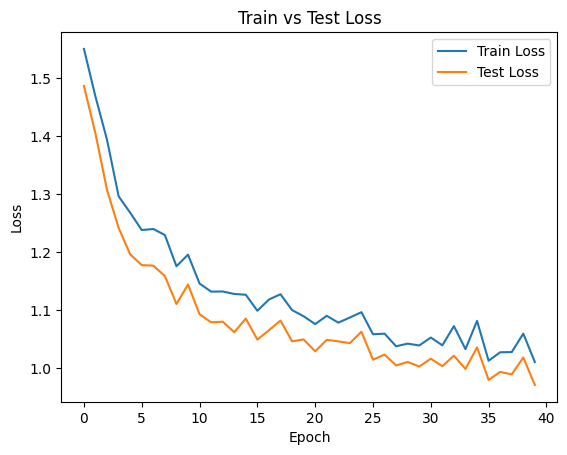

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

In [11]:
# テスト画像による精度の検証
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# 10000枚のテスト画像に対するCNNの精度
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
import zipfile
import os
import shutil

# パスの設定
zip_path = "/content/drive/MyDrive/CIFAR-10/test.zip"
extract_path = "/content/test_images"

# zip解凍
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [14]:
transform_testtest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

In [15]:
from torch.utils.data import Dataset
from PIL import Image
import os


In [16]:
# カスタムDataset作成
class UnlabeledImageDataset(Dataset):
    # def __init__(self, image_dir, transform=None):
    #     self.image_dir = image_dir
    #     self.image_paths = sorted([os.path.join(image_dir, fname)
    #                                for fname in os.listdir(image_dir)
    #                                if fname.endswith(".png") or fname.endswith(".jpg")])

    #     self.transform = transform
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.tmp_image_paths = sorted([os.path.join(image_dir, fname)
                                   for fname in os.listdir(image_dir)
                                   if fname.endswith(".png") or fname.endswith(".jpg")])
        self.image_paths = [None] * len(self.tmp_image_paths)
        # print(len(self.tmp_image_paths))
        for path in self.tmp_image_paths:
          path_number = ""
          for path_index in range(-5, -14,-1):
            # print(path_index)
            # print(path[path_index])
            if path[path_index] in ["0","1","2","3","4","5","6","7","8","9"]:
              path_number += path[path_index]
            else:
              break
          # print(path_number)
          path_number = int(path_number[::-1])
          self.image_paths[path_number-1] = path

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        # print(img_path)
        return image  # ラベルなしなのでimageだけ返す

In [17]:
testtest = UnlabeledImageDataset("/content/test_images", transform=transform_testtest)
testtestloader = torch.utils.data.DataLoader(testtest, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
import pandas as pd

# ラベル → クラス名の対応表
label_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

net.eval()
all_preds = []

with torch.no_grad():
    for images in testtestloader:
        images = images.to(device)
        outputs = net(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

# 数字 → クラス名に変換
class_preds = [label_names[i] for i in all_preds]

# CSV作成
df = pd.DataFrame({
    "Id": list(range(1,len(class_preds)+1)),
    "Label": class_preds
})

df.to_csv("submission.csv", index=False)
print("✅ submission.csv を出力しました！")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ submission.csv を出力しました！


In [ ]:
# print(len(df))
df